In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)

# Week 11: Clustering Analysis in Python

- Section 401
- Nov 13, 2023

## Clustering in Python

- Both spatial and non-spatial datasets
- Two new techniques: 
    - Non-spatial: **K-means**
    - Spatial: **DBSCAN**
- Two labs/exercises this week:
    1. Grouping Philadelphia neighborhoods by AirBnb listings
    1. Identifying clusters in taxi rides in NYC

## "Machine learning" and "AI"

![](imgs/machine_learning.jpg)

- The computer **learns** patterns and properties of an input data set without the user specifying them beforehand
- Can be both **supervised** and **unsupervised**

### Supervised
- Example: classification
- Given a training set of **labeled** data, learn to assign labels to new data

### Unsupervised
- Example: clustering
- Identify structure / clusters in data without any prior knowledge

## Machine learning in Python: scikit-learn

- State-of-the-art machine learning in Python
- Easy to use, lots of functionality

## Clustering is just one (of many) features

![](imgs/scikit_learn.png)

[https://scikit-learn.org/stable/](https://scikit-learn.org/stable/)


::: {.callout-note}
We will focus on clustering algorithms today and discuss a few other machine learning techniques in the next two weeks. If there is a specific scikit-learn use case we won't cover, I'm open to ideas for incorporating it as part of the final project. 

:::

## Part 1: Non-spatial clustering

**The goal**

Partition a dataset into groups that have a similar set of attributes, **or features**, within the group and a dissimilar set of features between groups.

Minimize the *intra-cluster* variance and maximize the *inter-cluster* variance of features.

### Some intuition

![](imgs/clustering.png)

### K-Means clustering

- Simple but robust clustering algorithm
- Widely used
- **Important:** user must specify the number of clusters
- **Cannot** be used to find density-based clusters

### This is just one of several clustering methods

[https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods](https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods)

::: {.callout-tip}
### A good introduction

Check out [Andrew Ng's Coursera lecture](https://www.youtube.com/watch?v=0D4LnsJr85Y) on unsupervised clustering.

:::

### How does it work?

**Minimizes the intra-cluster variance**: minimizes the sum of the squared distances between all points in a cluster and the cluster centroid

### K-means in action

![](imgs/K-means_convergence.gif)

### Example: Clustering countries by health and income

- Health expectancy in years vs. GDP per capita and population for 187 countries (as of 2015)
- Data from [Gapminder](https://www.gapminder.org/data/)

In [2]:
import altair as alt
from vega_datasets import data as vega_data

Read the data from a URL:

In [3]:
gapminder = pd.read_csv(vega_data.gapminder_health_income.url)
gapminder.head()

,country,income,health,population
0,Afghanistan,1925,57.63,32526562
1,Albania,10620,76.00,2896679
2,Algeria,13434,76.50,39666519
3,Andorra,46577,84.10,70473
4,Angola,7615,61.00,25021974


Plot it with altair:

In [4]:
(
    alt.Chart(gapminder)
    .mark_circle()
    .encode(
        alt.X("income:Q", scale=alt.Scale(type="log")),
        alt.Y("health:Q", scale=alt.Scale(zero=False)),
        size="population:Q",
        tooltip=list(gapminder.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

#### K-Means with scikit-learn

In [5]:
from sklearn.cluster import KMeans

Let's start with 5 clusters

In [6]:
KMeans?

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init='warn',
    max_iter=300,
    tol=0.0001,
    verbose=0,
    random_state=None,
    copy_x=True,
    algorithm='lloyd',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centroids using sampling based on
    an empirical probability distribution of the points' contribution to the
    overall inertia. This technique speeds up convergence. The algorithm
    implemented is "greedy k-means++". It differs from the vanilla k-means++
    by making several trials at each sampling step and choosing the best centroid
    among them.

    'random': cho

In [7]:
kmeans = KMeans(n_clusters=5, n_init=10)

Lot's of optional parameters, but `n_clusters` is the most important:

#### Let's fit just income first

Use the `fit()` function

In [8]:
kmeans.fit(gapminder[['income']]);

#### Extract the cluster labels

Use the `labels_` attribute

In [9]:
gapminder['label'] = kmeans.labels_

#### How big are our clusters?

In [10]:
gapminder.groupby('label').size()

label
0    106
1      6
2     50
3      1
4     24
dtype: int64

#### Plot it again, coloring by our labels

In [11]:
(
    alt.Chart(gapminder)
    .mark_circle()
    .encode(
        alt.X("income:Q", scale=alt.Scale(type="log")),
        alt.Y("health:Q", scale=alt.Scale(zero=False)),
        size="population:Q",
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(gapminder.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

#### Calculate average income by group

In [12]:
gapminder.groupby("label")['income'].mean().sort_values()

label
0      5279.830189
2     21040.820000
4     42835.500000
1     74966.166667
3    132877.000000
Name: income, dtype: float64

Data is nicely partitioned into income levels

#### How about health, income, and population?

In [13]:
# Fit all three columns
kmeans.fit(gapminder[['income', 'health', 'population']])

# Extract the labels
gapminder['label'] = kmeans.labels_

In [14]:
gapminder

,country,income,health,population,label
0,Afghanistan,1925,57.63,32526562,2
1,Albania,10620,76.00,2896679,2
2,Algeria,13434,76.50,39666519,0
3,Andorra,46577,84.10,70473,2
4,Angola,7615,61.00,25021974,2
...,...,...,...,...,...
182,Vietnam,5623,76.50,93447601,0
183,West Bank and Gaza,4319,75.20,4668466,2
184,Yemen,3887,67.60,26832215,2
185,Zambia,4034,58.96,16211767,2


In [15]:
(
    alt.Chart(gapminder)
    .mark_circle()
    .encode(
        alt.X("income:Q", scale=alt.Scale(type="log")),
        alt.Y("health:Q", scale=alt.Scale(zero=False)),
        size="population:Q",
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(gapminder.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

#### It....didn't work that well

What's wrong?

**K-means is distance-based, but our features have wildly different distance scales**

#### scikit-learn to the rescue: pre-processing

* Scikit-learn has a utility to normalize features with an average of zero and a variance of 1
* Use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class

In [16]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()

#### Use the `fit_transform()` function to scale your features

In [19]:
gapminder_scaled = scaler.fit_transform(gapminder[['income', 'health', 'population']])

**Important**: The `fit_transform()` function converts the DataFrame to a numpy array:

In [20]:
# fit_transform() converts the data into a numpy array
gapminder_scaled[:5]

array([[-0.79481258, -1.8171424 , -0.04592039],
       [-0.34333373,  0.55986273, -0.25325837],
       [-0.1972197 ,  0.62456075,  0.00404216],
       [ 1.52369617,  1.6079706 , -0.27303503],
       [-0.49936524, -1.38107777, -0.09843447]])

In [21]:
# mean of zero
gapminder_scaled.mean(axis=0)

array([ 8.07434927e-17, -1.70511258e-15, -1.89984689e-17])

In [22]:
# variance of one
gapminder_scaled.std(axis=0)

array([1., 1., 1.])

#### Now fit the scaled features

In [23]:
# Perform the fit
kmeans.fit(gapminder_scaled)

# Extract the labels
gapminder['label'] = kmeans.labels_

In [24]:
(
    alt.Chart(gapminder)
    .mark_circle()
    .encode(
        alt.X("income:Q", scale=alt.Scale(type="log")),
        alt.Y("health:Q", scale=alt.Scale(zero=False)),
        size="population:Q",
        color=alt.Color("label:N", scale=alt.Scale(scheme="dark2")),
        tooltip=list(gapminder.columns),
    )
    .properties(width=800, height=600)
    .interactive()
)

alt.Chart(...)

In [25]:
# Number of countries per cluster
gapminder.groupby("label").size()

label
0    62
1    85
2     5
3     2
4    33
dtype: int64

In [26]:
# Average population per cluster
gapminder.groupby("label")['population'].mean().sort_values() / 1e6

label
2       2.544302
0      21.191274
1      26.478761
4      31.674060
3    1343.549735
Name: population, dtype: float64

In [27]:
# Average life expectancy per cluster
gapminder.groupby("label")['health'].mean().sort_values()

label
0    62.342097
3    71.850000
1    74.376353
4    80.830303
2    80.920000
Name: health, dtype: float64

In [28]:
# Average income per cluster
gapminder.groupby("label")['income'].mean().sort_values() / 1e3

label
0     4.136016
3     9.618500
1    13.347376
4    41.048818
2    91.524200
Name: income, dtype: float64

In [29]:
gapminder.loc[gapminder['label']==4]

,country,income,health,population,label
3,Andorra,46577,84.1,70473,4
8,Australia,44056,81.8,23968973,4
9,Austria,44401,81.0,8544586,4
12,Bahrain,44138,79.2,1377237,4
16,Belgium,41240,80.4,11299192,4
30,Canada,43294,81.7,35939927,4
44,Cyprus,29797,82.6,1165300,4
45,Czech Republic,29437,78.6,10543186,4
46,Denmark,43495,80.1,5669081,4
58,Finland,38923,80.8,5503457,4


In [30]:
kmeans.inertia_

80.72009578392847

In [31]:
gapminder.loc[gapminder['label']==4]

,country,income,health,population,label
3,Andorra,46577,84.1,70473,4
8,Australia,44056,81.8,23968973,4
9,Austria,44401,81.0,8544586,4
12,Bahrain,44138,79.2,1377237,4
16,Belgium,41240,80.4,11299192,4
30,Canada,43294,81.7,35939927,4
44,Cyprus,29797,82.6,1165300,4
45,Czech Republic,29437,78.6,10543186,4
46,Denmark,43495,80.1,5669081,4
58,Finland,38923,80.8,5503457,4


### Exercise: Clustering neighborhoods by Airbnb stats

I've extracted neighborhood Airbnb statistics for Philadelphia neighborhoods from [Tom Slee's website](http://tomslee.net/airbnb-data).

The data includes average price per person, overall satisfaction, and number of listings.

::: {.callout-note}
### Two good references for Airbnb data

- [Tom Slee's website](http://tomslee.net/airbnb-data)
- [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

Original research study: [How Airbnb's Data Hid the Facts in New York City](http://insideairbnb.com/reports/how-airbnbs-data-hid-the-facts-in-new-york-city.pdf)

:::

#### Step 1: Load the data with pandas

The data is available in CSV format ("philly_airbnb_by_neighborhoods.csv") in the "data/" folder of the repository.

#### Step 2: Perform the K-Means fit

- Use our three features: `price_per_person`, `overall_satisfaction`, `N`
- I used 5 clusters, but you are welcome to experiment with different values! We will discuss what the *optimal* number is after we go through the solutions!
- Scaling the features is recommended, but if the scales aren't too different, so probably isn't necessary in this case

#### Step 3: Calculate average features per cluster

To gain some insight into our clusters, after calculating the K-Means labels:
- group by the `label` column
- calculate the `mean()` of each of our features
- calculate the number of neighborhoods per cluster

#### Step 4: Plot a choropleth, coloring neighborhoods by their cluster label

- Part 1: Load the Philadelphia neighborhoods available in the data directory:  
    - `./data/philly_neighborhoods.geojson`
- Part 2: Merge the Airbnb data (with labels) and the neighborhood polygons
- Part 3: Use geopandas to plot the neighborhoods
    - The `categorical=True` and `legend=True` keywords will be useful here

#### Step 5: Plot an interactive map

Use hvplot / geopandas to plot the clustering results with a tooltip for neighborhood name and tooltip.

#### Based on these results, where would you want to stay?




### Why 5 groups? 

Use the ["Elbow" method](https://en.wikipedia.org/wiki/Elbow_method_(clustering))...

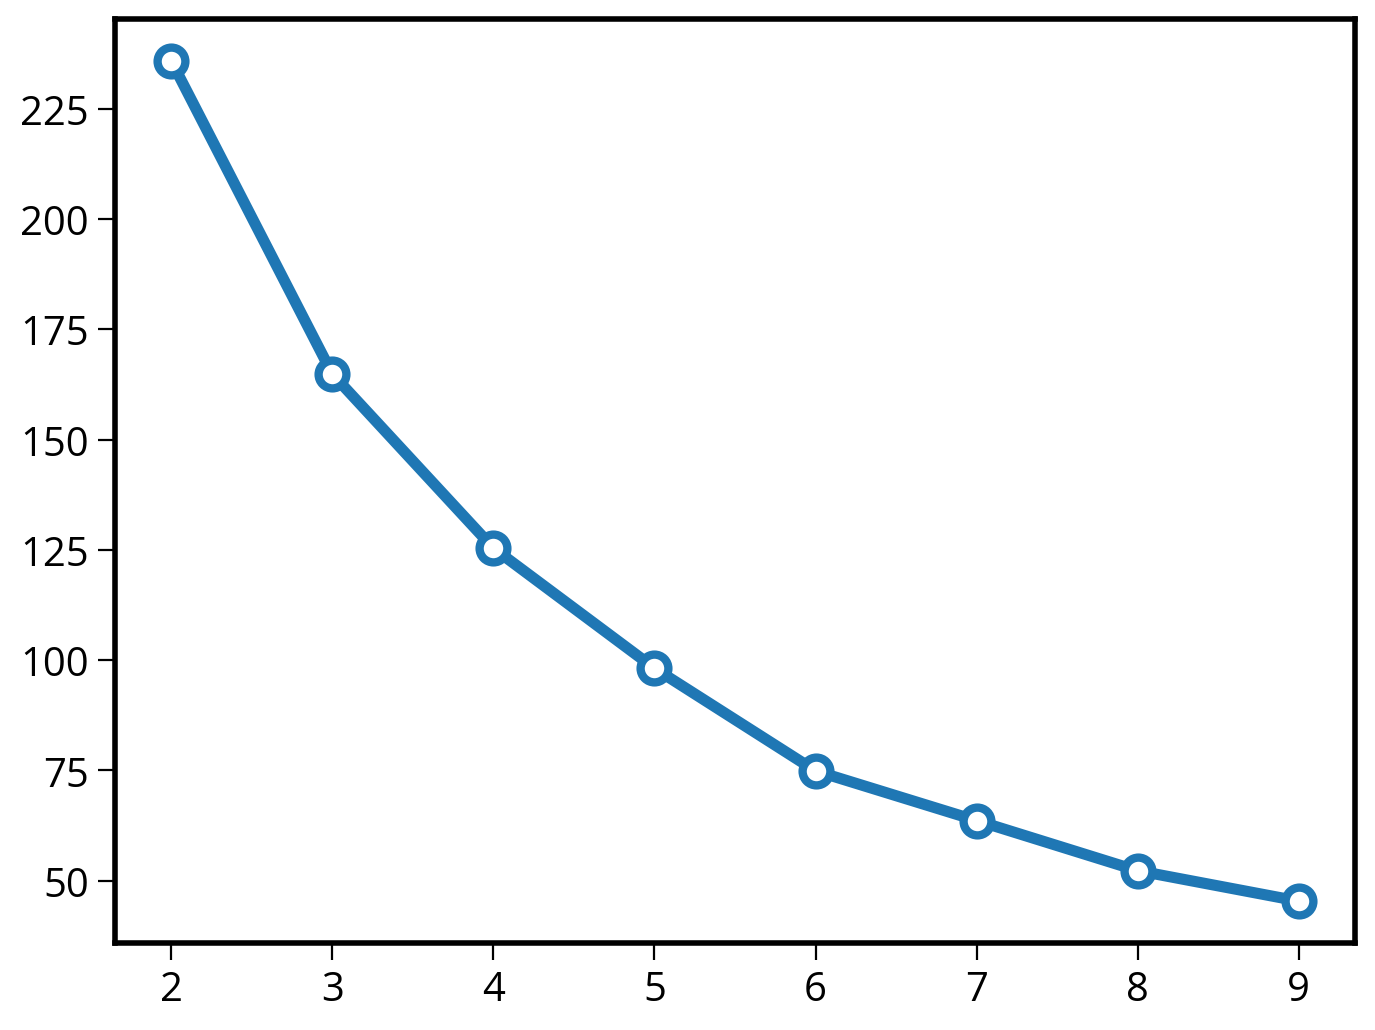

In [50]:
# Number of clusters to try out
n_clusters = list(range(2, 10))

# Run kmeans for each value of k
inertias = []
for k in n_clusters:
    
    # Initialize and run
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(scaled_airbnb_data)
    
    # Save the "inertia"
    inertias.append(kmeans.inertia_)
    
# Plot it!
plt.plot(n_clusters, inertias, marker='o', ms=10, mfc='white', lw=4, mew=3);

### The `kneed` package

There is also a nice package called kneed that can determine the “knee” point quantitatively, using the [kneedle algorithm](https://raghavan.usc.edu/papers/kneedle-simplex11.pdf).

In [51]:
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9]

In [52]:
from kneed import KneeLocator

# Initialize the knee algorithm
kn = KneeLocator(n_clusters, inertias, curve='convex', direction='decreasing')

# Print out the knee 
print(kn.knee)

5


## That's it!

More clustering on Wednesday!